# 导入所需的库

In [51]:
import numpy as np
from pylab import *
from sklearn.metrics import davies_bouldin_score
import random
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体（解决中文无法显示的问题） 
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号“-”显示方块的问题

# 数据导入与预处理，观察数据分布情况（分布图只用于后面和聚类后的分布图做比较）

In [52]:
#从txt中读入数据并data，绘制所有数据点的分布图
class import_data:
    def __init__(self, txt_name,title):
        self.txt_name = txt_name
        self._x = []
        self._y = []
        self.data = None  # All data
        self.num = None  # Number of data points
        self.title=title
        

    def load_txt(self):
        f = open((self.txt_name + '.txt'), encoding='gbk')
        x = self._x
        y = self._y
        for line in f:
            a, b = map(float, line.split())
            x.append(a)
            y.append(b)
        self.data = np.column_stack((x, y))
        self.num = len(x)

    def plot_data(self):
        title=self.title
        plt.scatter(self.data[:, 0], self.data[:, 1], marker='o', label='数据点')
        plt.title(title)
        plt.xlabel('X轴')
        plt.ylabel('Y轴')
        plt.legend()
        plt.show()

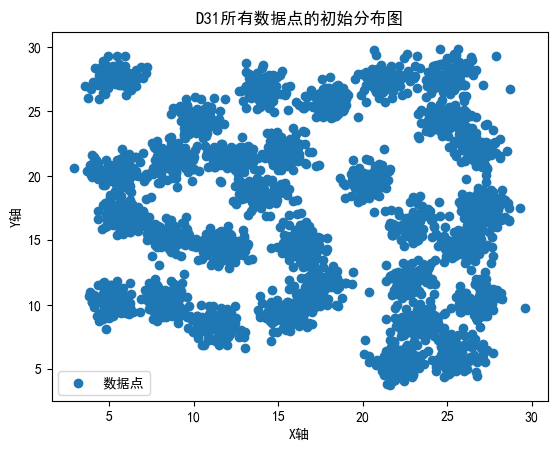

In [53]:
#D31图像
D31=import_data('D31','D31所有数据点的初始分布图')
D31.load_txt()
data_D31=D31.data
num_D31=D31.num
D31.plot_data()

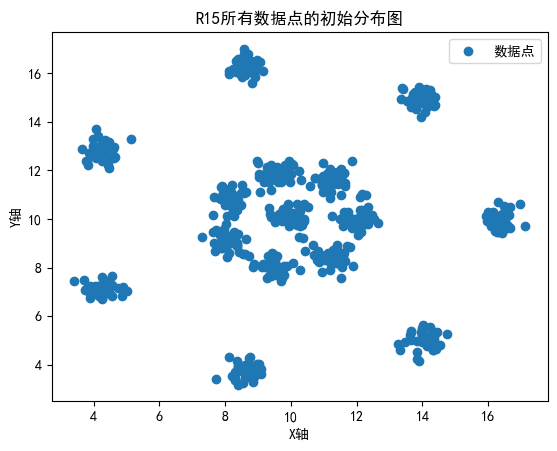

In [54]:
#R15图像
R15=import_data('R15','R15所有数据点的初始分布图')
R15.load_txt()
data_R15=R15.data
num_R15=R15.num
R15.plot_data()

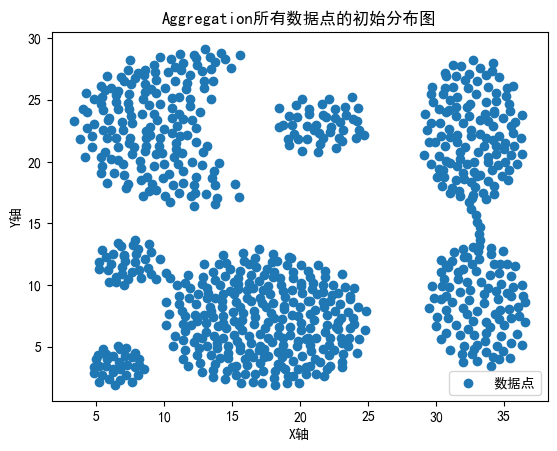

In [55]:
#Aggregation图像
Aggregation=import_data('Aggregation','Aggregation所有数据点的初始分布图')
Aggregation.load_txt()
data_Aggregation=Aggregation.data
num_Aggregation=Aggregation.num
Aggregation.plot_data()

# DPC算法实现部分

In [68]:

class DPC_process:
    def __init__(self,dc,data,num):#,threshold_rho, threshold_delta):
        self.data = data  # 所有数据，使用np储存
        self.num = num  # 数据量
        self.dc = dc  # 阈值dc
        self.p=None  #密度
        self._distance=None #距离的中间变量，如dij等
        self.sigma=None #
        self.clusters = None #聚类情况


    def distance_ij(self, data_i, data_j):
        return np.sqrt(np.sum((data_i - data_j) ** 2))

    #计算密度
    def compute_p_and_distance(self):
        data=self.data
        num = self.num
        p = np.zeros(num)
        distance = np.zeros((num, num))
        for i in range(num):
            for j in range(num):
                distance[j][i]=distance[i][j] = self.distance_ij(data[i], data[j])
                if distance[i][j] < self.dc:
                    p[i] += 1
        self.p=p
        self._distance=distance

    def compute_sigma(self):
        num=self.num
        sigma=np.zeros(num)
        for i in range(num):
            sigma[i]= float('inf')  
            #初始化为inf，求所有p[j]>p[i]的j中dij最小的，计入sigma[i]
            for j in range(num):
                if self.p[j] > self.p[i] and self._distance[i][j] < sigma[i]:
                    sigma[i] = self._distance[i][j]
            #对具有最大密度的i，另外定义
            if sigma[i] == float('inf'):
                sigma[i]=0
                for j in range(num):
                    if self._distance[i][j] > sigma[i]:
                        sigma[i]=self._distance[i][j]
        self.sigma=sigma
        
    def remove_ood_points(self,threshold_rho, threshold_delta):
        # 根据设定的阈值，将OOD点从数据集中去除
        ood_indices = np.where((self.p < threshold_rho) & (self.sigma > threshold_delta))[0]
        self.data = np.delete(self.data, ood_indices, axis=0)
        self.p=np.delete(self.p, ood_indices, axis=0)
     
    def find_center(self,min_sigma):
        center_indices = np.where(self.sigma > min_sigma)[0]
        print (len(center_indices))
        
    def classify_data_points(self,min_sigma):
        threshold_sigma = min_sigma  
        #peaks是所有簇中心的索引值集合
        peaks = np.where(self.sigma > threshold_sigma)[0]

        #cluster字典保存结果
        clusters = {peak: [] for peak in peaks}

        for i in range(self.num):
            distances = [self.distance_ij(self.data[i], self.data[peak])for peak in peaks]
            closest_peak = peaks[np.argmin(distances)]
            clusters[closest_peak].append(self.data[i])

        self.clusters = clusters
                        

In [168]:
#绘制聚类后的图
def plot_clusters(clusters, data):
    color = plt.cm.tab20c.colors

    # 生成不同的标记和颜色
    markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', '+', 'x', '|', '_', '<', '>', ',', '.', '1', '2', '3', '4', '8']
    colors = color[:31]

    for peak, cluster_points in clusters.items():
        cluster_color = colors[peak % len(colors)]  # 根据聚类中心的索引选择颜色
        marker = markers[(peak % 73) % len(markers)]# 根据聚类中心的索引选择标记样式

        cluster_points = np.array(cluster_points)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=cluster_color, marker=marker, label=f'Cluster {peak}')

    plt.title('Clustered Data Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='lower right', bbox_to_anchor=(1.2, 1.0), ncol=5, fancybox=True, shadow=True)
    plt.show()


# 调用DPC并检验结果

In [84]:
#调用DPC_process，传入参数
DPC_D31=DPC_process(2,data_D31,num_D31)
DPC_D31.compute_p_and_distance()
DPC_D31.compute_sigma()
D31_p=DPC_D31.p
D31_sigma=DPC_D31.sigma

In [85]:
#查看选定值对应的簇中心的个数
DPC_D31.find_center(2)

31


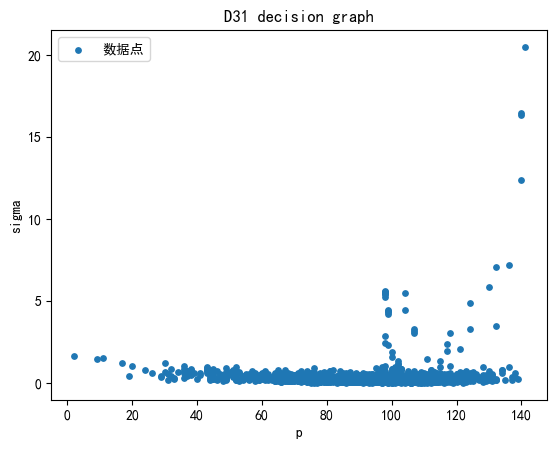

In [86]:
#画出决策图
plt.scatter(D31_p,D31_sigma , marker='o', label='数据点',s=15)
plt.title('D31 decision graph')
plt.xlabel('p')
plt.ylabel('sigma')
plt.legend()
plt.show()

In [87]:
#移除异常点，根据选定的聚类中心应该有的最小sigma值求出簇的情况
DPC_D31.remove_ood_points(20,2)
DPC_D31.classify_data_points(2)
for peak, cluster_points in DPC_D31.clusters.items():
    print(f'Cluster {peak}: {cluster_points}')

Cluster 116: [array([18.4941, 12.5877]), array([18.1606, 12.5486]), array([17.7558, 12.1231]), array([18.3607, 11.8287]), array([17.2866, 12.2933]), array([18.0272, 12.6176]), array([17.1026, 13.1719]), array([17.5212, 11.8747]), array([16.7898, 12.2128]), array([16.638 , 12.9649]), array([18.5125, 11.8425]), array([17.9306, 12.1898]), array([17.6132, 13.4686]), array([18.4642, 11.7137]), array([17.3625, 12.0035]), array([17.5419, 11.8885]), array([17.8961, 11.8057]), array([18.2365, 11.7666]), array([18.3653, 12.0633]), array([19.3635, 11.6286]), array([16.9853, 12.3186]), array([18.0272, 11.9621]), array([16.845 , 12.9235]), array([17.4384, 12.2128]), array([17.9421, 11.8057]), array([16.615 , 12.0702]), array([16.7415, 11.8793]), array([16.8197, 12.1162]), array([17.8363, 11.8563]), array([17.696 , 11.9414]), array([18.5378, 11.6516]), array([17.1877, 11.9828]), array([18.1422, 11.9966]), array([18.4803, 12.0955]), array([17.4982, 11.9552]), array([19.3934, 12.5601]), array([17.9651

C:\Users\CindyWu\AppData\Local\Temp\ipykernel_3052\2444662521.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=cluster_color, marker=marker, label=f'Cluster {peak}')


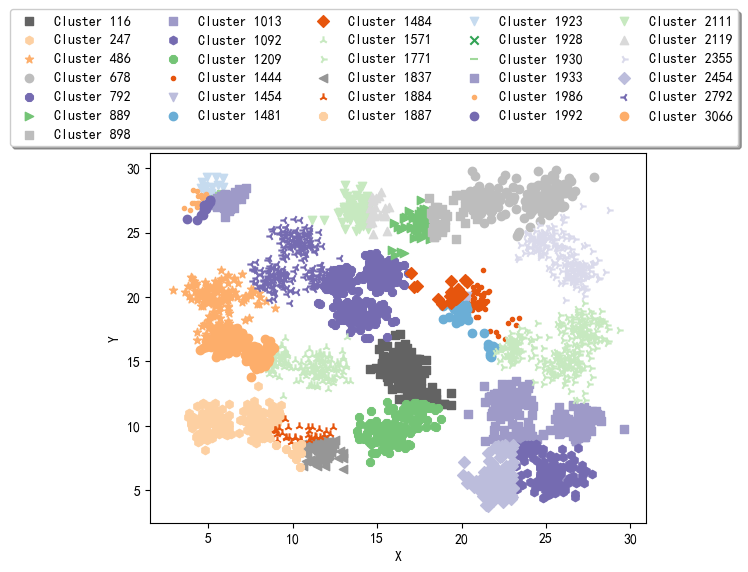

Davies-Bouldin Index: 1.0092478670357166


In [169]:
#可视化聚类情况
plot_clusters(DPC_D31.clusters, data_D31)
clusters = list(DPC_D31.clusters.values())
cluster_labels = [label for label, points in enumerate(clusters) for _ in range(len(points))]
data_points = np.concatenate(clusters)

# 计算DBI
db_index = davies_bouldin_score(data_points, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")

In [133]:
#调用DPC_process，传入参数
DPC_R15=DPC_process(0.5,data_R15,num_R15)
DPC_R15.compute_p_and_distance()
DPC_R15.compute_sigma()
R15_p=DPC_R15.p
R15_sigma=DPC_R15.sigma

In [134]:
#查看选定值对应的簇中心的个数
DPC_R15.find_center(2)

14


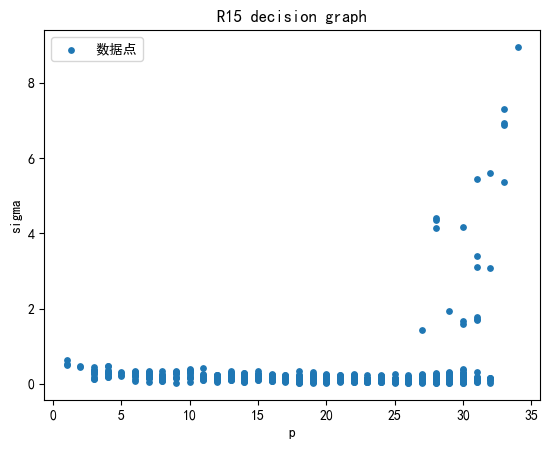

In [170]:
#画出决策图
plt.scatter(R15_p,R15_sigma , marker='o', label='数据点',s=15)
plt.title('R15 decision graph')
plt.xlabel('p')
plt.ylabel('sigma')
plt.legend()
plt.show()


In [136]:
#移除异常点，根据选定的聚类中心应该有的最小sigma值求出簇的情况
DPC_R15.remove_ood_points(5,2)
DPC_R15.classify_data_points(2)
for peak, cluster_points in DPC_R15.clusters.items():
    print(f'Cluster {peak}: {cluster_points}')

Cluster 91: [array([10.062, 10.26 ]), array([10.284, 10.348]), array([10.386, 10.608]), array([10.172, 10.598]), array([10.514, 10.498]), array([12.04 , 10.028]), array([12.082, 10.044]), array([12.4  , 10.156]), array([12.348, 10.488]), array([11.736, 10.122]), array([11.246, 10.122]), array([12.276, 10.99 ]), array([12.364, 10.176]), array([12.458, 10.18 ]), array([11.628, 10.286]), array([11.736, 10.29 ]), array([12.114, 10.904]), array([12.164, 11.018]), array([11.808, 10.058]), array([11.594, 10.078]), array([12.176, 10.364]), array([12.104, 10.388]), array([11.372, 11.466]), array([10.94 , 11.482]), array([11.084, 11.554]), array([11.232, 11.374]), array([11.22, 11.64]), array([10.962, 11.75 ]), array([11.014, 11.746]), array([11.524, 10.982]), array([11.012, 11.364]), array([11.2  , 11.062]), array([11.626, 11.894]), array([11.23 , 11.728]), array([11.144, 11.91 ]), array([11.106, 11.868]), array([11.53 , 11.918]), array([11.21 , 11.114]), array([10.746, 11.702]), array([11.154,

C:\Users\CindyWu\AppData\Local\Temp\ipykernel_3052\2444662521.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=cluster_color, marker=marker, label=f'Cluster {peak}')


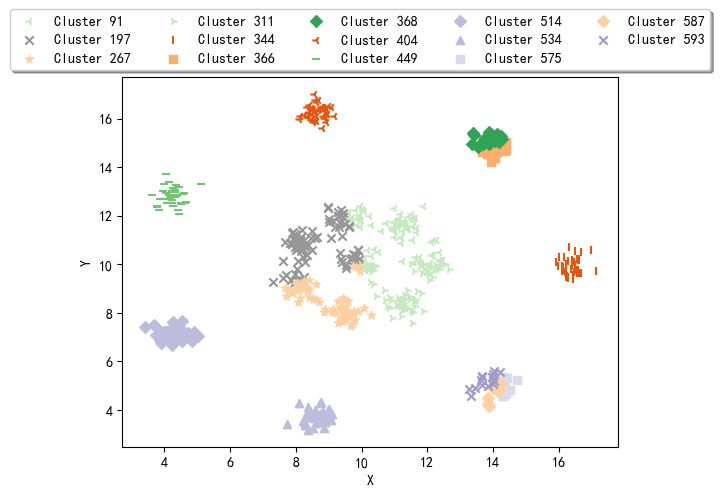

Davies-Bouldin Index: 0.7578623482040675


In [171]:
#可视化聚类情况
plot_clusters(DPC_R15.clusters, data_Aggregation)
clusters = list(DPC_R15.clusters.values())
cluster_labels = [label for label, points in enumerate(clusters) for _ in range(len(points))]
data_points = np.concatenate(clusters)

# 计算 Davies-Bouldin Index
db_index = davies_bouldin_score(data_points, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")

In [137]:
DPC_Aggregation=DPC_process(1,data_Aggregation,num_Aggregation)
DPC_Aggregation.compute_p_and_distance()
DPC_Aggregation.compute_sigma()
Aggregation_p=DPC_Aggregation.p
Aggregation_sigma=DPC_Aggregation.sigma

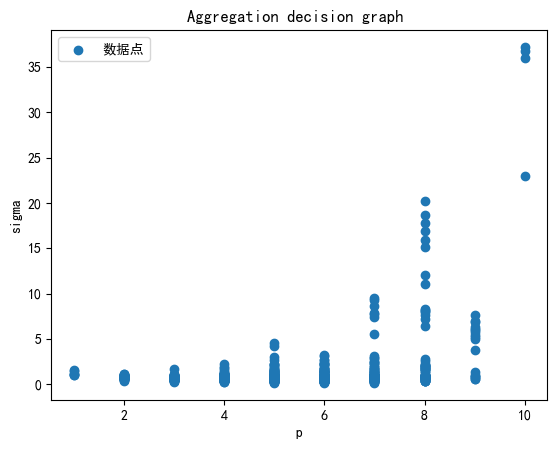

In [172]:
plt.scatter(Aggregation_p,Aggregation_sigma , marker='o', label='数据点')
plt.title('Aggregation decision graph ')
plt.xlabel('p')
plt.ylabel('sigma')
plt.legend()
plt.show()

In [153]:
DPC_Aggregation.find_center(18)

6


In [154]:
#移除异常点，根据选定的聚类中心应该有的最小sigma值求出簇的情况
DPC_Aggregation.remove_ood_points(2,18)
DPC_Aggregation.classify_data_points(18)
for peak, cluster_points in DPC_Aggregation.clusters.items():
    print(f'Cluster {peak}: {cluster_points}')

Cluster 40: [array([15.55, 28.65]), array([14.9 , 27.55]), array([14.45, 28.35]), array([14.15, 28.8 ]), array([13.75, 28.05]), array([13.35, 28.45]), array([13.  , 29.15]), array([13.45, 27.5 ]), array([13.6, 26.5]), array([12.8 , 27.35]), array([12.4 , 27.85]), array([12.3, 28.4]), array([12.2 , 28.65]), array([13.4, 25.1]), array([12.95, 25.95]), array([12.9, 26.5]), array([11.85, 27.  ]), array([11.35, 28.  ]), array([11.15, 28.7 ]), array([11.25, 27.4 ]), array([10.75, 27.7 ]), array([10.5 , 28.35]), array([ 9.65, 28.45]), array([10.25, 27.25]), array([10.75, 26.55]), array([11.7 , 26.35]), array([11.6, 25.9]), array([11.9 , 25.05]), array([12.6 , 24.05]), array([11.9, 24.5]), array([11.1, 25.2]), array([10.55, 25.15]), array([10.05, 25.95]), array([ 9.35, 26.6 ]), array([ 9.3 , 27.25]), array([ 9.2, 27.8]), array([ 7.5 , 28.25]), array([ 8.55, 27.45]), array([ 8.5 , 27.05]), array([ 8.05, 27.2 ]), array([ 7.85, 26.8 ]), array([ 7.3, 27.4]), array([ 6.8 , 26.85]), array([ 7. , 26.

C:\Users\CindyWu\AppData\Local\Temp\ipykernel_3052\2444662521.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=cluster_color, marker=marker, label=f'Cluster {peak}')


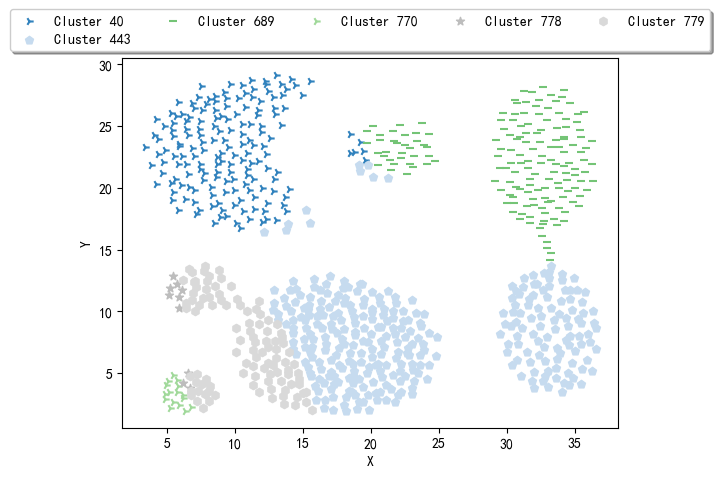

Davies-Bouldin Index: 0.9603906897996589


In [173]:
#可视化聚类情况
plot_clusters(DPC_Aggregation.clusters, data_Aggregation)
clusters = list(DPC_Aggregation.clusters.values())
cluster_labels = [label for label, points in enumerate(clusters) for _ in range(len(points))]
data_points = np.concatenate(clusters)

# 计算DBI
db_index = davies_bouldin_score(data_points, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")